In [1]:
import pyBigWig

In [2]:
import pandas as pd
foldn="fold3"
bed_annotate = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/auprc_curves/K562/idr_overlap_peak_blacklist_annotated_"+foldn+".bed"
chr1_binned = pd.read_csv(bed_annotate, sep="\t", names=["chr", "start", "end", "idr", "idr_f", "idr_t", "idr_w", "idr_frac", 
                                                         "bkt", "op"])
chr1_binned = chr1_binned[:-1]
print(chr1_binned.shape)

#chr1_binned["mappability"] = mappability
chr1_binned["label"] = 0
chr1_binned.loc[chr1_binned["idr"]==1, "label"] =1
print(sum(chr1_binned["label"]))

(6180123, 10)
118185


In [3]:
chr1_binned.head()

,chr,start,end,idr,idr_f,idr_t,idr_w,idr_frac,bkt,op,label
0,chr5,557,657,0,0,0,100,0.0,0,0,0
1,chr5,657,757,0,0,0,100,0.0,0,0,0
2,chr5,757,857,0,0,0,100,0.0,0,0,0
3,chr5,857,957,0,0,0,100,0.0,0,0,0
4,chr5,957,1057,0,0,0,100,0.0,0,0,0


In [4]:
import numpy as np
chrm = None
values = []
chromsize={}
chroms = chr1_binned['chr'].unique().tolist()



for chrm in chroms:
    bww="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/auprc_curves/K562/ATAC/K562_"+foldn+"_"+chrm+"_w_bias.bw"
    pred_bigwig = pyBigWig.open(bww,"r")
    chrmsz = pred_bigwig.chroms(chrm)
    print(chrm, chrmsz)
    
    
    filtered_df = chr1_binned[chr1_binned['chr'] == chrm]
    # Find the maximum value in the 'value' column
#     max_value = filtered_df['end'].max()
#     print(chrm, chrmsz, max_value)
    chromsize[chrm] = [filtered_df.shape[0], chrmsz]
    
    all_val = np.nan_to_num(pred_bigwig.values(chrm, 0, chrmsz))
    atac = [sum(all_val[i:i+100]) for i in range(557,chromsize[chrm][1], 100)][0:chromsize[chrm][0]]
    values.extend(atac)
        

chr5 181538259
chr10 133797422
chr14 107043718
chr18 80373285
chr20 64444167
chr22 50818468


In [5]:
len(values)

6180123

In [6]:
chr1_binned["atac"] = values

In [7]:
import numpy as np
import gzip

mappability = []
for chrm in chroms:

    with gzip.open("/mnt/lab_data2/anusri/chrombpnet/reference/mappability/"+chrm+'.uint8.unique.gz', 'rb') as tmp_uMap:
        uMapdata = np.frombuffer(tmp_uMap.read(), dtype=np.uint8)

    pos_vec = (uMapdata>0)&(uMapdata<=101)
    pos_vec = pos_vec.astype(int)
    neg_vec = np.roll(pos_vec, 100)
    neg_vec[0:100] = 0

    print(set(pos_vec))
    print(len(uMapdata))
    print(sum(pos_vec))

    total_map=pos_vec+neg_vec
    mappability.extend([sum(total_map[i:i+100])/200 for i in range(557,chromsize[chrm][1], 100)][0:chromsize[chrm][0]])


{0, 1}
181538259
173265497
{0, 1}
133797422
128386272
{0, 1}
107043718
86455216
{0, 1}
80373285
74065690
{0, 1}
64444167
60805387
{0, 1}
50818468
34191158


In [8]:
len(mappability)

6180123

In [9]:
chr1_binned["mappability"] = mappability


In [10]:
chr1_binned=chr1_binned[chr1_binned["bkt"]==0]


In [11]:
chr1_binned.head()

,chr,start,end,idr,idr_f,idr_t,idr_w,idr_frac,bkt,op,label,atac,mappability
0,chr5,557,657,0,0,0,100,0.0,0,0,0,7.199708,0.0
1,chr5,657,757,0,0,0,100,0.0,0,0,0,7.199708,0.0
2,chr5,757,857,0,0,0,100,0.0,0,0,0,7.199708,0.0
3,chr5,857,957,0,0,0,100,0.0,0,0,0,7.199708,0.0
4,chr5,957,1057,0,0,0,100,0.0,0,0,0,7.199708,0.0


In [12]:
chr1_binned = chr1_binned[~((chr1_binned["idr_frac"]>0) & (chr1_binned["idr_frac"]<0.5))]

In [13]:
chr1_binned = chr1_binned[~((chr1_binned["op"]==1) & (chr1_binned["idr"]==0))]
print(chr1_binned.shape)

(5882455, 13)


In [14]:
sum(chr1_binned["idr"]==1)

118185

In [15]:
chr1_binned = chr1_binned[chr1_binned["mappability"]>0.5]

In [16]:
import sklearn.metrics

print("ATAC 572M",np.round(sklearn.metrics.average_precision_score(chr1_binned["label"],chr1_binned["atac"]),2))


ATAC 572M 0.37


In [17]:
sum(chr1_binned["label"])/chr1_binned.shape[0]

0.02135109030116009

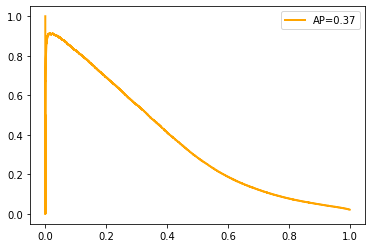

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(chr1_binned["label"].astype(int), abs(chr1_binned["atac"]))
roc_auc = metrics.average_precision_score(chr1_binned["label"], abs(chr1_binned["atac"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, c='orange', label="AP="+str(round(roc_auc,2)))
plt.legend()

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
roc_auc_score(chr1_binned["label"],  abs(chr1_binned["atac"]))

0.8823482982654056

In [21]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(chr1_binned["label"], chr1_binned["atac"])
auc = metrics.auc(fpr, tpr)

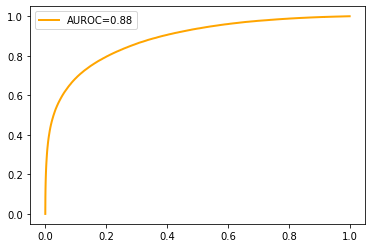

In [22]:
plt.plot(fpr, tpr,  linewidth=2, c='orange', label="AUROC="+str(round(auc,2)))
plt.legend()